In [25]:
import os
import pandas as pd
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ls: cannot access 'chess': No such file or directory
ls: cannot access 'piece': No such file or directory
ls: cannot access 'detection': No such file or directory
Number of images per class:
queen: 34
rook: 72
bishop: 67
king: 34
knight: 71
pawn: 239


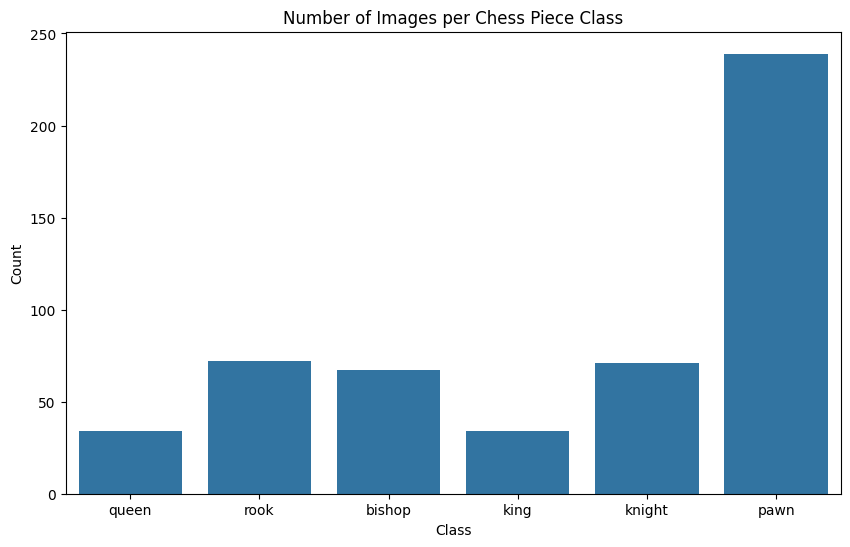

In [26]:
# Path to your zip file
zip_file_path = 'chess piece detection.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('chess piece detection')

# Verify extraction
!ls chess piece detection
# Path to the extracted dataset folder
data_dir = 'chess piece detection/data'

# List the classes and count the number of images in each class
classes = os.listdir(data_dir)
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

print("Number of images per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Plot the count of images per class
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=class_counts_df)
plt.title('Number of Images per Chess Piece Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# **Data Preprocessing**

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
# Set the dimensions for resizing images
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Function to load and preprocess images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img)
            labels.append(label)
    return images, labels

# Load and preprocess images for all classes
data_dir = 'chess piece detection/data'
classes = os.listdir(data_dir)
all_images = []
all_labels = []

for idx, cls in enumerate(classes):
    class_folder = os.path.join(data_dir, cls)
    images, labels = load_images_from_folder(class_folder, idx)
    all_images.extend(images)
    all_labels.extend(labels)

# Convert lists to arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Normalize the pixel values
all_images = all_images / 255.0

# Convert labels to categorical format
all_labels = to_categorical(all_labels, num_classes=len(classes))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (413, 128, 128, 3)
Validation data shape: (104, 128, 128, 3)


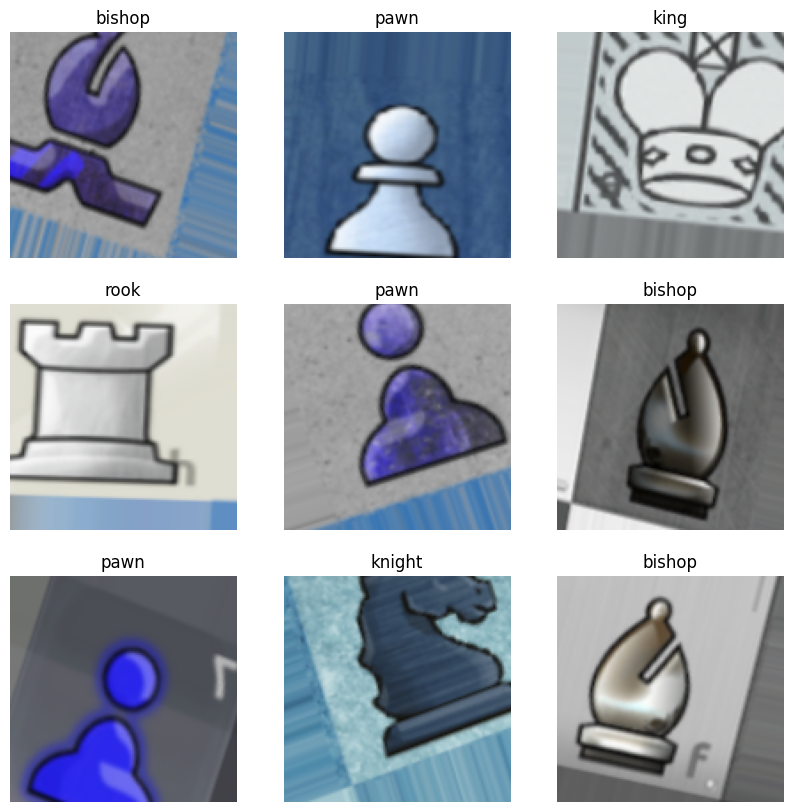

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Fit the data generators to the data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Display some augmented images
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(classes[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

# **EDA**

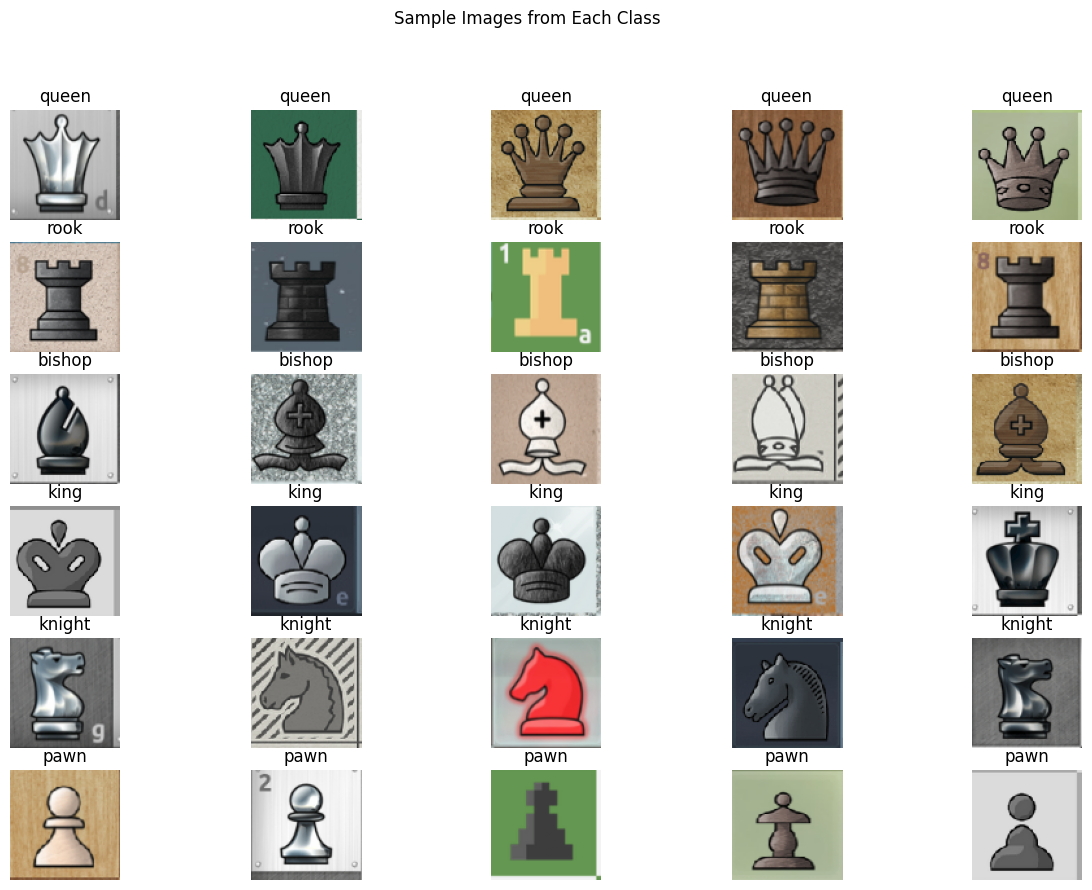

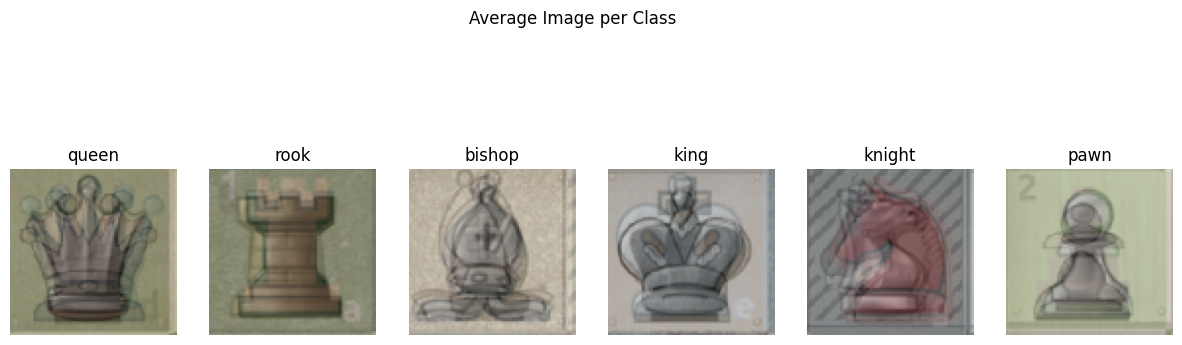

In [29]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Initialize lists to store image sizes and sample images
image_sizes = []
sample_images = {}
# Load images to analyze sizes and collect sample images
for cls in classes:
    class_folder = os.path.join(data_dir, cls)
    sample_images[cls] = []
    for filename in os.listdir(class_folder):
        img_path = os.path.join(class_folder, filename)
        img = load_img(img_path)
        img_array = img_to_array(img)
        image_sizes.append(img_array.shape[:2])
        if len(sample_images[cls]) < 5:  # Collect 5 sample images per class
            sample_images[cls].append(img_array)

# Convert image sizes to a numpy array for analysis
image_sizes = np.array(image_sizes)

# 1. Display Sample Images
fig, axes = plt.subplots(len(classes), 5, figsize=(15, 10))
for idx, cls in enumerate(classes):
    for i in range(5):
        axes[idx, i].imshow(sample_images[cls][i] / 255.0)
        axes[idx, i].set_title(cls)
        axes[idx, i].axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

# 2. Average Image per Class
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for idx, cls in enumerate(classes):
    avg_img = np.mean(sample_images[cls], axis=0) / 255.0
    axes[idx].imshow(avg_img)
    axes[idx].set_title(cls)
    axes[idx].axis('off')
plt.suptitle('Average Image per Class')
plt.show()

# **CNN**

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator)


Epoch 1/100
13/13 [==============================] - 3s 175ms/step - loss: 1.7021 - accuracy: 0.4044 - val_loss: 1.6305 - val_accuracy: 0.4135
Epoch 2/100
13/13 [==============================] - 2s 158ms/step - loss: 1.6017 - accuracy: 0.4770 - val_loss: 1.6263 - val_accuracy: 0.4135
Epoch 3/100
13/13 [==============================] - 2s 148ms/step - loss: 1.5574 - accuracy: 0.4746 - val_loss: 1.6557 - val_accuracy: 0.4135
Epoch 4/100
13/13 [==============================] - 2s 151ms/step - loss: 1.5780 - accuracy: 0.4746 - val_loss: 1.6101 - val_accuracy: 0.4135
Epoch 5/100
13/13 [==============================] - 2s 150ms/step - loss: 1.5372 - accuracy: 0.4746 - val_loss: 1.6183 - val_accuracy: 0.4135
Epoch 6/100
13/13 [==============================] - 2s 155ms/step - loss: 1.5281 - accuracy: 0.4746 - val_loss: 1.5299 - val_accuracy: 0.4135
Epoch 7/100
13/13 [==============================] - 2s 158ms/step - loss: 1.4924 - accuracy: 0.4746 - val_loss: 1.4511 - val_accuracy: 0.4135

In [43]:
model.evaluate(val_generator)

4/4 [==============================] - 0s 21ms/step - loss: 0.1191 - accuracy: 0.9712


[0.11905435472726822, 0.9711538553237915]

In [44]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy}")

# Get predictions and true labels
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate precision, recall, and F1-score
report = classification_report(y_true, y_pred_classes, target_names=classes)
print("Classification Report:\n", report)

4/4 [==============================] - 0s 20ms/step - loss: 0.1191 - accuracy: 0.9712
Validation Accuracy: 0.9711538553237915
4/4 [==============================] - 0s 24ms/step
Classification Report:
               precision    recall  f1-score   support

       queen       0.11      0.11      0.11         9
        rook       0.17      0.16      0.16        19
      bishop       0.11      0.10      0.11        10
        king       0.00      0.00      0.00         7
      knight       0.07      0.06      0.06        16
        pawn       0.35      0.37      0.36        43

    accuracy                           0.21       104
   macro avg       0.13      0.13      0.13       104
weighted avg       0.20      0.21      0.21       104



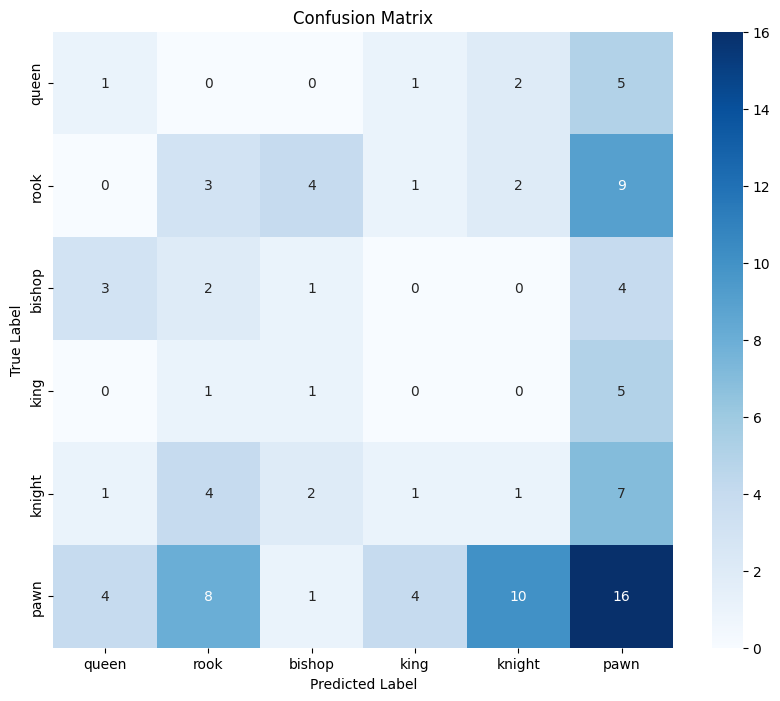

In [45]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

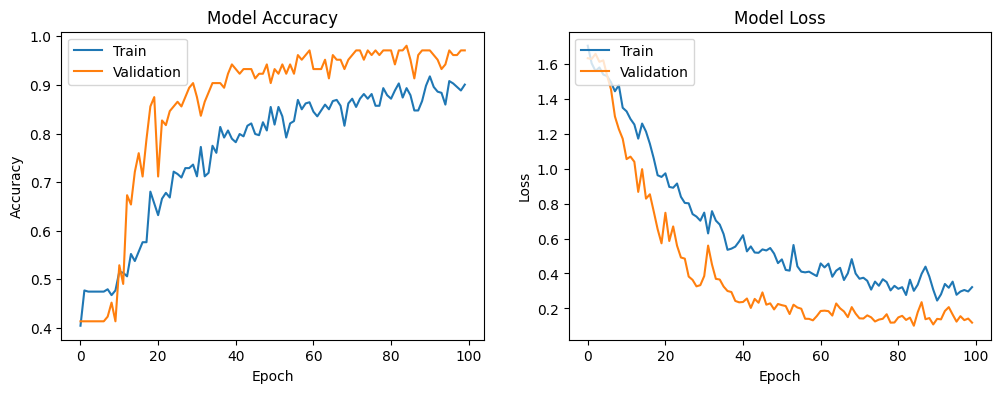

In [46]:
# Plot epochs vs. loss/accuracy graph
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 [==============================] - 0s 87ms/step


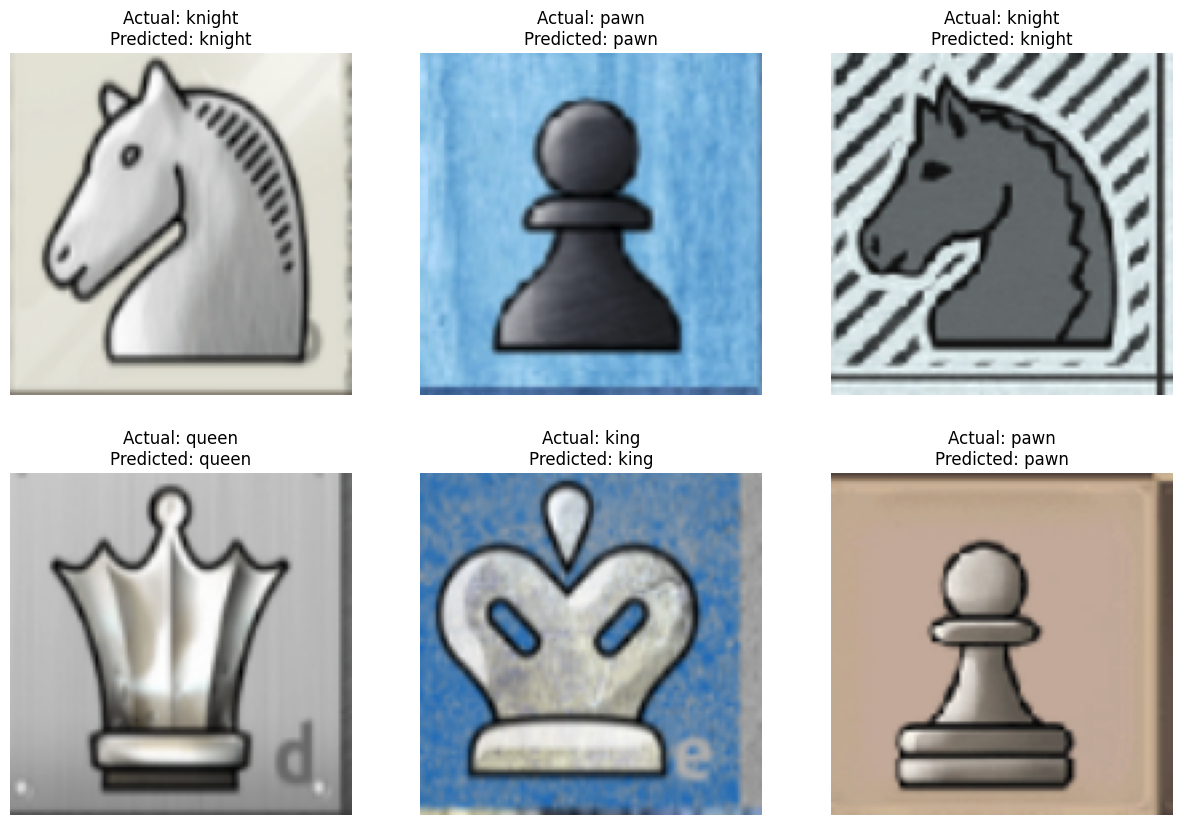

In [47]:
from tensorflow.keras.preprocessing.image import array_to_img

# Select six random validation images
indices = np.random.choice(len(X_val), 6, replace=False)
selected_images = X_val[indices]
selected_labels = y_val[indices]

# Predict using the trained model
predictions = model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(selected_labels, axis=1)

# Convert indices to class names
class_names = [classes[i] for i in true_classes]
predicted_class_names = [classes[i] for i in predicted_classes]

# Plot the images with predicted and actual classes
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    img = array_to_img(selected_images[i])
    plt.imshow(img)
    plt.title(f"Actual: {class_names[i]}\nPredicted: {predicted_class_names[i]}")
    plt.axis('off')
plt.show()

Saving test.jpeg to test.jpeg
Uploaded file: test.jpeg
1/1 [==============================] - 0s 31ms/step


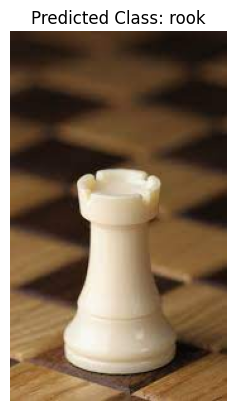

Predicted Class: rook


In [48]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 1: Upload the Image
uploaded = files.upload()

# Retrieve the filename of the uploaded image
uploaded_filename = next(iter(uploaded))
print(f"Uploaded file: {uploaded_filename}")

# Step 2: Preprocess the Image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Preprocess the uploaded image
image_path = uploaded_filename
preprocessed_image = preprocess_image(image_path)

# Step 3: Make Predictions
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class_name = classes[predicted_class_index]

# Step 4: Display the Prediction
img = load_img(image_path)
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')
plt.show()

print(f"Predicted Class: {predicted_class_name}")


In [49]:
# Save the model to a .h5 file
model.save('final_chess.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0
